# Analyzing NYC High School Data in 2011
---

We explored relationships between [SAT](https://en.wikipedia.org/wiki/SAT) scores and demographic factors in New York City public schools. For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on [student SAT scores](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) by high school, along with additional demographic data sets. Over the last three missions, we combined the following data sets into a single, clean pandas dataframe:

- [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

### Prerequisite

#### 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
sns.set_style('ticks')

#### 2. Read in the data

In [3]:
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

#### 3. Read in the surveys

In [4]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

#Creating a new column with capitalized DBN
survey["DBN"] = survey["dbn"]

#selecting the useful columns from the survey data
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

### Data Cleaning

#### 1. Add DBN columns

In [5]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

#### 2. Convert columns to numeric

In [6]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

#### 5. Condense datasets

In [7]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

#### 3. Convert AP scores to numeric

In [8]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

#### 4. Combine the datasets

In [9]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

#### 5. Add a school district column for mapping

In [10]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

#### 6. Removing DBN column

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

### Plotting and Analysis

#### 1. Find correlations

In [12]:
correlations = combined.corr()['sat_score'][survey_fields]
#changing the index names
correlations = correlations.rename(index={
    "N_p":'Parents - n-respondents',
    'rr_p':'Parents - response rate',
    "saf_p_11":"Parents - safety & respect", 
    "com_p_11":"Parents - communication", 
    "eng_p_11":"Parents - engagement", 
    "aca_p_11":"Parents - academic expectations",
    "saf_t_11":"Teachers - safety & respect", 
    "com_t_11":"Teachers - communication", 
    "eng_t_11":"Teachers - engagement", 
    "N_t":'Teachers - n-respondents',
    'rr_t':'Teachers - response rate',
    "aca_t_11":"Teachers - academic expectations", 
    "saf_s_11":"Students - safety & respect",
    "N_s":'Students - n-respondents',
    'rr_s':'Students - response rate',
    "com_s_11":"Students - communication", 
    "eng_s_11":"Students - engagement", 
    "aca_s_11":"Students - academic expectations", 
    "saf_tot_11":"Total - safety & respect", 
    "com_tot_11":"Total - communication", 
    "eng_tot_11":"Total - engagement", 
    "aca_tot_11":"Total - academic expectations"})

print(correlations)

Students - response rate            0.232199
Teachers - response rate           -0.023386
Parents - response rate             0.047925
Students - n-respondents            0.423463
Teachers - n-respondents            0.291463
Parents - n-respondents             0.421530
Parents - safety & respect          0.122913
Parents - communication            -0.115073
Parents - engagement                0.020254
Parents - academic expectations     0.035155
Teachers - safety & respect         0.313810
Teachers - communication            0.082419
Teachers - engagement               0.036906
Teachers - academic expectations    0.132348
Students - safety & respect         0.337639
Students - communication            0.187370
Students - engagement               0.213822
Students - academic expectations    0.339435
Total - safety & respect            0.318753
Total - communication               0.077310
Total - engagement                  0.100102
Total - academic expectations       0.190966
Name: sat_

#### 2. Plotting correlations between survey of parents,teachers, and students to SAT scores

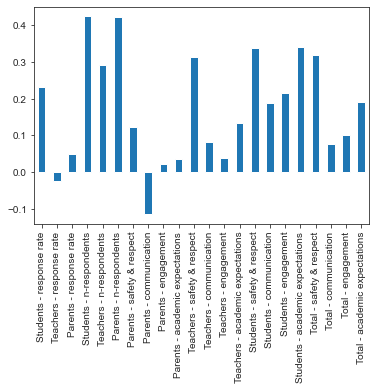

In [13]:
correlations.plot.bar()

After observing the graph which plots the correlation between SAT Scores and survey results, we find that there are high correlations between number of students and parents response

Student's response rate has some correlation to SAT scores but maybe misleading since those who filled out the survey tend to score highly.

Turns out safety is quite important for both teachers and students. A safe learning environment promotes a better studying and working environment for the students and teachers respectively.

It is quite interesting how academic standard affects SAT scores. Parents' and teachers' academic standard have lower impact on SAT scores when compared to student's. 

#### 3. Investigating safety scores and SAT scores

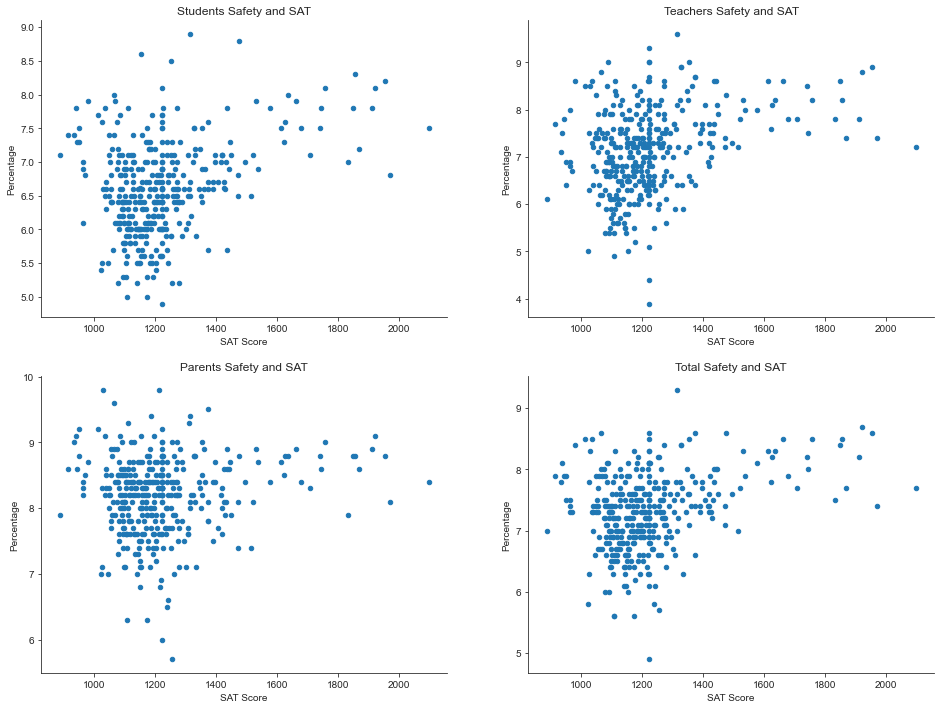

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,12))
#Plotting saf_s_11 and SAT_score
combined.plot(x='sat_score',y='saf_s_11',kind='scatter',
              ax=axs[0,0],title='Students Safety and SAT')
combined.plot(x='sat_score',y='saf_t_11',kind='scatter',
              ax=axs[0,1],title='Teachers Safety and SAT')
combined.plot(x='sat_score',y='saf_p_11',kind='scatter',
              ax=axs[1,0],title='Parents Safety and SAT')
combined.plot(x='sat_score',y='saf_tot_11',kind='scatter',
              ax=axs[1,1],title='Total Safety and SAT')

for i in range(2):
    for j in range(2):
        axs[i,j].set_ylabel('Percentage')
        axs[i,j].set_xlabel('SAT Score')
        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)

This graph confirms what we had seen from the previous graph which is there is a weak positive correlation between SAT score and safety for all parties (student, teachers, and parents). Per usual, we can see that there are schools which have high safety and sat score and the opposite holds true too.

In [15]:
#Finding average student safety score for each borough
ave_saf_s=combined.groupby('boro').agg(np.mean)
ave_saf_s['saf_s_11']

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64

Based on the mean for student's safety score, we can see that Manhattan and Queens scored the highest while Brooklyn scored the lowest.

#### 4. Correlation between racial percentage and SAT score

In [16]:
unique_race=['asian_per', 'black_per', 'hispanic_per', 'white_per']
unique_race

['asian_per', 'black_per', 'hispanic_per', 'white_per']

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

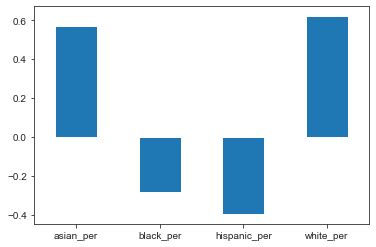

In [17]:
combined.corr()['sat_score'][unique_race].plot.bar()
plt.xticks(rotation=0)

Based on the graphic above, we can see that Asian and Whites tend to do better in the SAT test (both have positive correlation) while African-American and Hispanic tend to not (both have negative correlation).

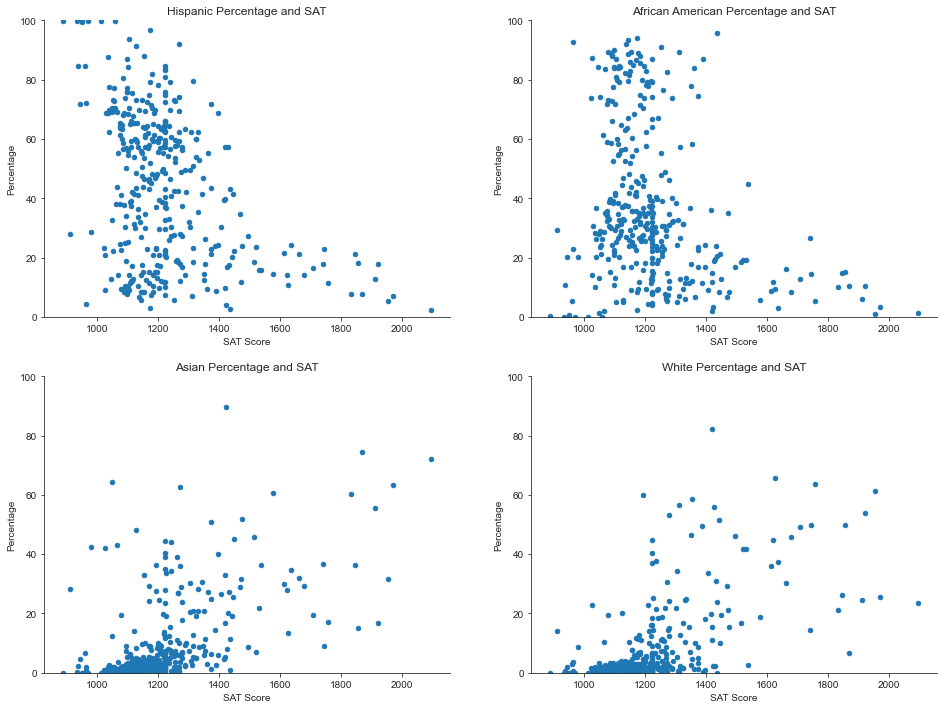

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,12))

#Plotting race percentage and SAT_score
combined.plot(x='sat_score',y='hispanic_per',kind='scatter',
              ax=axs[0,0],title='Hispanic Percentage and SAT',ylim=(0,100))
combined.plot(x='sat_score',y='black_per',kind='scatter',
              ax=axs[0,1],title='African American Percentage and SAT',ylim=(0,100))
combined.plot(x='sat_score',y='asian_per',kind='scatter',
              ax=axs[1,0],title='Asian Percentage and SAT',ylim=(0,100))
combined.plot(x='sat_score',y='white_per',kind='scatter',
              ax=axs[1,1],title='White Percentage and SAT',ylim=(0,100))

for i in range(2):
    for j in range(2):
        axs[i,j].set_ylabel('Percentage')
        axs[i,j].set_xlabel('SAT Score')
        axs[i,j].spines["top"].set_visible(False)
        axs[i,j].spines["right"].set_visible(False)


It is clear to see that there is a quite strong negative relationship between hispanic percentage and SAT scores. SAT scores tend to drop when there is an incease in hispanic percentage. It is also the same case for African-Americans.

Whites and Asians have the exact opposite, their replationship is quite strong (eventhough the data is clusttered in a specific range)

In [19]:
#Finding schools which have higher than 95% hispanic percentage
combined[combined['hispanic_per']>95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools on the list above are geared toward imigrant students which might affect SAT scores since the test is taken in English.

In [20]:
#Finding schools with <10% hispanic percentage and SAT scores>1800

combined[(combined['hispanic_per']<10)&
        (combined['sat_score']>1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools on the list above are science and tech specialized schools which require an entry exam to enter. They are also some of the best ranked high schools in the US, thus explain why the students have higher SAT scores. That being said, the reason why the amount of hispanic percentage cannot be explained by that detail alone.

#### 5. Correlation between gender and SAT score

In [21]:
gender_unique=['male_per','female_per']
gender_unique

['male_per', 'female_per']

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

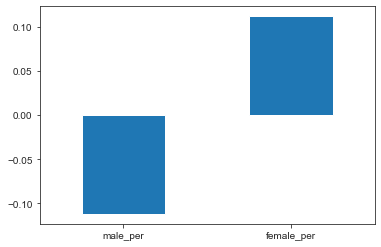

In [22]:
combined.corr()['sat_score'][gender_unique].plot.bar()
plt.xticks(rotation=0)

There is a relatively weak correlation between gender and SAT scores. Female tend to do better (seen from its positive correlation) compared to male (negative correlation).

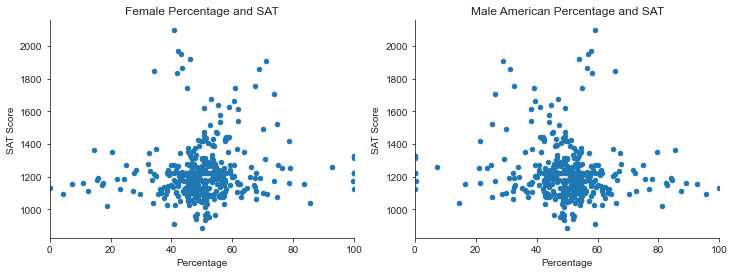

In [23]:
#Investigating SAT scores and percentage

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

#Plotting race percentage and SAT_score
combined.plot(x='female_per',y='sat_score',kind='scatter',
              ax=axs[0],title='Female Percentage and SAT',xlim=(0,100))
combined.plot(x='male_per',y='sat_score',kind='scatter',
              ax=axs[1],title='Male American Percentage and SAT',xlim=(0,100))

for i in range(2):
    axs[i].set_xlabel('Percentage')
    axs[i].set_ylabel('SAT Score')
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)


It is interesting that higher SAT scores came from schools which have a 1:1 gender split and also schools which have 60 to 80 female percentage tend to have higher SAT scores. But other than that, there is no clear pattern to observe here.

In [24]:
#Schools which have female percentage>60 and SAT score>1700
combined[(combined['female_per']>60)&(combined['sat_score']>1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

A quick Google search showed that the schools on the list above are liberal arts schools. They are also selective and acedemically inclined

#### 5. Correlation between AP test  and SAT scores

In [25]:
#creating a new column to avoid data bias
combined['ap_per']=combined['AP Test Takers ']/combined['total_enrollment']
combined['ap_per'].head(3)

0    0.305756
1    0.098985
2    0.031773
Name: ap_per, dtype: float64

Text(0.5, 1.0, 'AP Score vs SAT')

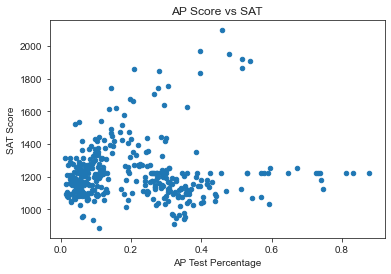

In [26]:
combined.plot.scatter('ap_per','sat_score')
plt.xlabel('AP Test Percentage')
plt.ylabel('SAT Score')
plt.title('AP Score vs SAT')

The graph indicates that there is little to no correlation (extremely weak) between AP test and SAT score.

#### 6. Correlation between class size and SAT Scores

Text(0.5, 1.0, 'Average Class Size vs SAT')

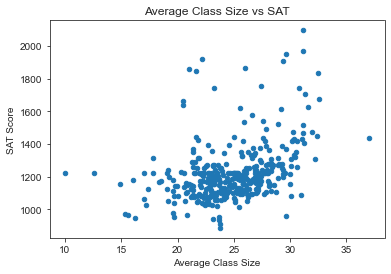

In [27]:
combined.plot.scatter("AVERAGE CLASS SIZE",'sat_score')
plt.xlabel('Average Class Size')
plt.ylabel('SAT Score')
plt.title('Average Class Size vs SAT')

After analyzing the graph, it is clear to see that there is a positive correlation between average class size and SAT scores. The correlation itself is quite strong.

### Conclusion

After doing some analysis, we can conclude that:
1. Safety and gender has a weak effect on SAT scores.
2. Race where the increase or decrease of a certain race percentage will increase or decrease the SAT scores. The races with negative correlation are African-American and Hispanic, while White and Asian have positive correlation.
3. The increase in the average class size will increase the SAT score by some margin.